# Open Exploration

In order to do an open exploration we need to examine the Uncertainty Space and Policy Space. For this cause we run the following sets of data on the Delft Blue Supercomputer:

- Policy space: **policy_space_refsc_265pol** : 265 different policies on the reference scenario
- Uncertainty space: **uncertainty_space_1024sc_refpol**: 10.000 scenarios with the reference policy


## Analysis of the Uncertainty Space
In order to investigate the effects and interactions of the different combinations of measures, 10.000 scenario's were run on the reference policy -> where no investments are made yet. This run was sampled by the sobol sampler in order to cover the sampling space.


### 1. Import the run results
Import the tar.gz file and make a dataframe containing all policy levers and outcomes.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style('white')

from ema_workbench.util import utilities

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

from new_problem_formulation import new_get_model_for_problem_formulation

Import the results, make dataframes out of the experiments and the outcomes and then combine into a big dataframe called policy_space.

In [2]:
# Load the results from the tar.gz file
results = utilities.load_results('data/uncertainty_space_1024sc_refpol.tar.gz')
pol_experiments, pol_outcomes = results

# Convert the damage_sobol array to a DataFrame
pol_experiments_df = pd.DataFrame(pol_experiments)

# Save the damage_sobol DataFrame to a CSV file
pol_experiments_df.to_csv('uncertainty_experiments.csv', index=False)

# Convert the outcomes_sobol dictionary to DataFrames and save each to a CSV file
for outcome_name, outcome_data in pol_outcomes.items():
    # Convert each outcome array to a DataFrame
    outcome_df = pd.DataFrame(outcome_data)
    
    # Save each DataFrame to a CSV file named after the outcome
    outcome_df.to_csv(f'{outcome_name}_uncertainty.csv', index=False)
    
# pol_experiments_df

In [3]:
# Convert outcomes_sobol dictionary to df
uncertainty_outcomes_df = pd.DataFrame.from_dict(pol_outcomes)
# uncertainty_outcomes_df.columns

In [4]:
# Merge DataFrames based on their index
uncertainty_space = pd.merge(pol_experiments_df, uncertainty_outcomes_df, left_index=True, right_index=True)

# Save the merged DataFrame to a CSV file
uncertainty_space.to_csv('uncertainty_space.csv', index=True)

# uncertainty_space.head()

### 2. Add aggregate outcomes columns in the policy_space

In [5]:
# Create the 'Overall Dike Increase Costs' column
uncertainty_space['Overall Dike Increase Costs'] = uncertainty_space.filter(like='Dike Investment Costs').sum(axis=1)

# Create the 'Overall Deaths' column
uncertainty_space['Overall Deaths'] = uncertainty_space.filter(like='Expected Number of Deaths').sum(axis=1)

# Create the 'Overall Damage' column
uncertainty_space['Overall Damage'] = uncertainty_space.filter(like='Expected Annual Damage').sum(axis=1)

# Create the 'Aggregated Investment' column
uncertainty_space['Aggregated Investment'] = (
    uncertainty_space['Overall Dike Increase Costs'] +
    uncertainty_space['RfR Total Costs'] +
    uncertainty_space['Expected Evacuation Costs']
)

# Create the 'Project and Damage Costs' column
uncertainty_space['Project and Damage Costs'] = (
    uncertainty_space['Aggregated Investment'] +
    uncertainty_space['Overall Damage']
)

uncertainty_space

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Overall Dike Increase Costs,Overall Deaths,Overall Damage,Aggregated Investment,Project and Damage Costs
0,84,263.056509,1.0,0.219760,78.144942,10.0,0.351234,164.221961,1.5,0.560215,...,0,4.084370e+06,0.002917,0.0,0.0,0,2.021064,3.818556e+09,0.0,3.818556e+09
1,95,263.056509,1.0,0.219760,78.144942,10.0,0.351234,164.221961,1.5,0.560215,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.002299,3.790728e+09,0.0,3.790728e+09
2,84,136.877426,1.0,0.219760,78.144942,10.0,0.351234,164.221961,1.5,0.560215,...,0,7.780937e+07,0.055619,0.0,0.0,0,2.095083,3.924552e+09,0.0,3.924552e+09
3,84,263.056509,1.5,0.219760,78.144942,10.0,0.351234,164.221961,1.5,0.560215,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.018147,3.814471e+09,0.0,3.814471e+09
4,84,263.056509,1.0,0.700748,78.144942,10.0,0.351234,164.221961,1.5,0.560215,...,0,3.235585e+08,0.231929,0.0,0.0,0,0.428766,6.054949e+08,0.0,6.054949e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,101,215.175934,1.5,0.215158,302.991676,1.5,0.850631,254.416809,10.0,0.752553,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.038602,2.779016e+09,0.0,2.779016e+09
40956,101,215.175934,1.5,0.215158,302.991676,1.5,0.850631,254.416809,10.0,0.752553,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.038602,3.315175e+09,0.0,3.315175e+09
40957,101,215.175934,1.5,0.215158,302.991676,1.5,0.850631,254.416809,10.0,0.752553,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.038602,2.779016e+09,0.0,2.779016e+09
40958,101,215.175934,1.5,0.215158,302.991676,1.5,0.850631,254.416809,10.0,0.752553,...,0,0.000000e+00,0.000000,0.0,0.0,0,2.038602,2.407332e+09,0.0,2.407332e+09


In [6]:
# Translate the policy space dataframe back into a dictionary in order for the sobol calculations to work
uncertainty_space_dict = {col: uncertainty_space[col].to_numpy() for col in uncertainty_space.columns}
# uncertainty_space_dict

In [7]:
results = utilities.load_results('data/uncertainty_space_1024sc_refpol.tar.gz')
un_experiments, un_outcomes = results

model, steps = new_get_model_for_problem_formulation(3)
uncertainties = model.uncertainties
levers = model.levers

In [8]:
# un_outcomes

### 3. Visualise Sobol effects (Total, First- and second order interactions)

In [9]:
# Function used to flatten Sobol S2 Dictionary Output

def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        array = []
        for row in value:
            array.extend(row)
        flattened_dict[key] = array

    return flattened_dict

In [10]:
def plot_sobol_effects(run_dict, variable, order, timestep):
    # Prepare Sobol Variables
    problem = get_SALib_problem(uncertainties)
    outcome_var = variable
    Si = sobol.analyze(problem, run_dict[outcome_var], print_to_console=False)
    
    
    if order == 'first':
        # Process Dataframe: Filter S1+ST
        Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
        
        if timestep == 'all':
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df[['S1','ST']]
            err = Si_df[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
                
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            
            # Filter Si_df based on filtered_names
            Si_df_filtered = Si_df.loc[filtered_names]
            
            # Visualize Sobol indices for filtered names
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = Si_df_filtered[['S1','ST']]
            err = Si_df_filtered[['S1_conf','ST_conf']]
            
            fig.set_size_inches(20,6)
            
    if order =='second':
        
        if timestep == 'all':
            Si_filter_s2 = {k:Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index= list(itertools.product(problem['names'], repeat=2)))
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

            # Filter out rows where S2 is greater than 0.1
            S2_df_filtered = S2_df_sorted[S2_df_sorted['S2'] <= 0.1]

            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            indices = S2_df_filtered[["S2"]]
            err = S2_df_filtered[['S2_conf']]
            
            fig.set_size_inches(20,6)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
            
            
        else:
            if timestep== '0':
                i=['1','2']
            elif timestep== '1':
                i=['0','2']
            elif timestep== '2':
                i=['0','1']
            # Filter out names that do not end with '1' or '2'
            filtered_names = [name for name in problem['names'] if not (name.endswith(i[0]) or name.endswith(i[1]))]
            combinations = list(itertools.product(filtered_names, repeat=2))
            
            # Assuming Si_filter_s2 and S2_df are generated as in your code snippet
            Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
            S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))
            
            # Sort S2_df by 'S2' in descending order
            S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)
            S2_df_filtered = S2_df_sorted.loc[combinations]
            
            # Visualize Sobol indices
            sns.set_style('white')
            fig, ax = plt.subplots(1)
            
            # Drop NaN values from 'S2' and 'S2_conf' columns
            indices = S2_df_filtered[["S2"]].dropna()
            err = S2_df_filtered[['S2_conf']].dropna()
            
            fig.set_size_inches(30,10)
            ax.axhline(y=0, color='r', linestyle='-', linewidth=2)  # Adding red line at y=0
    
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.suptitle(f'{variable} {order} order sobol effects ({timestep})', fontsize=15, y=0.93)
    fig.subplots_adjust(bottom=0.3)
    
    plt.show()
    return

## Overall Deaths Analysis 
First and Second order sobol effects

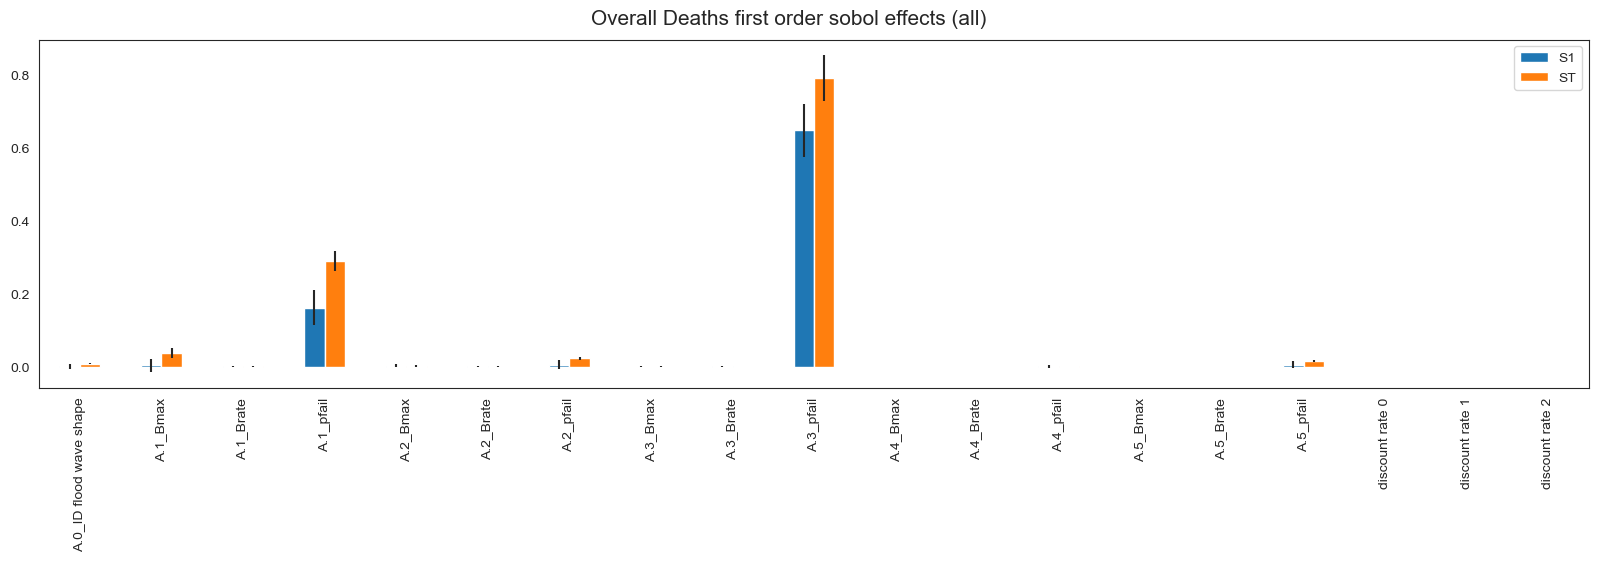

In [11]:
plot_sobol_effects(uncertainty_space_dict,'Overall Deaths', 'first','all')

In [12]:
# plot_sobol_effects(uncertainty_space_dict,'Overall Deaths', 'first','0')
# plot_sobol_effects(uncertainty_space_dict,'Overall Deaths', 'first','1')
# plot_sobol_effects(uncertainty_space_dict,'Overall Deaths', 'first','2')

## Overall Damages Analysis 
First and Second order sobol effects

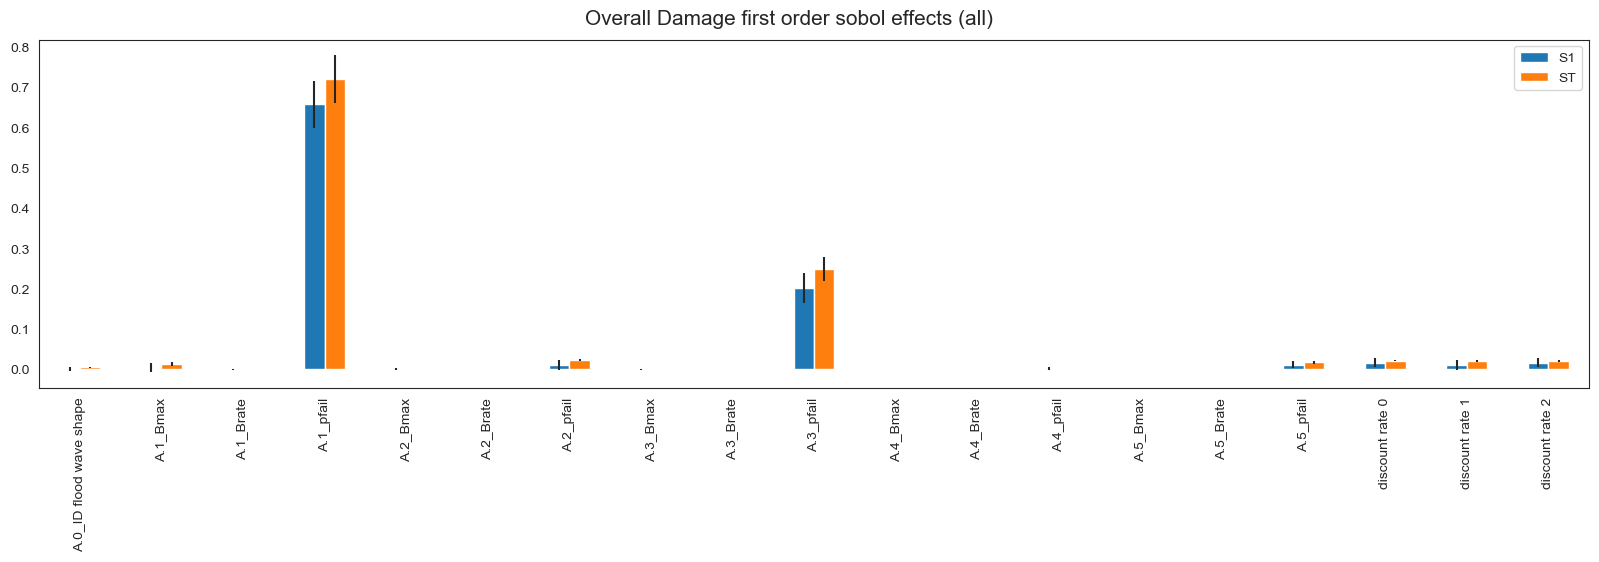

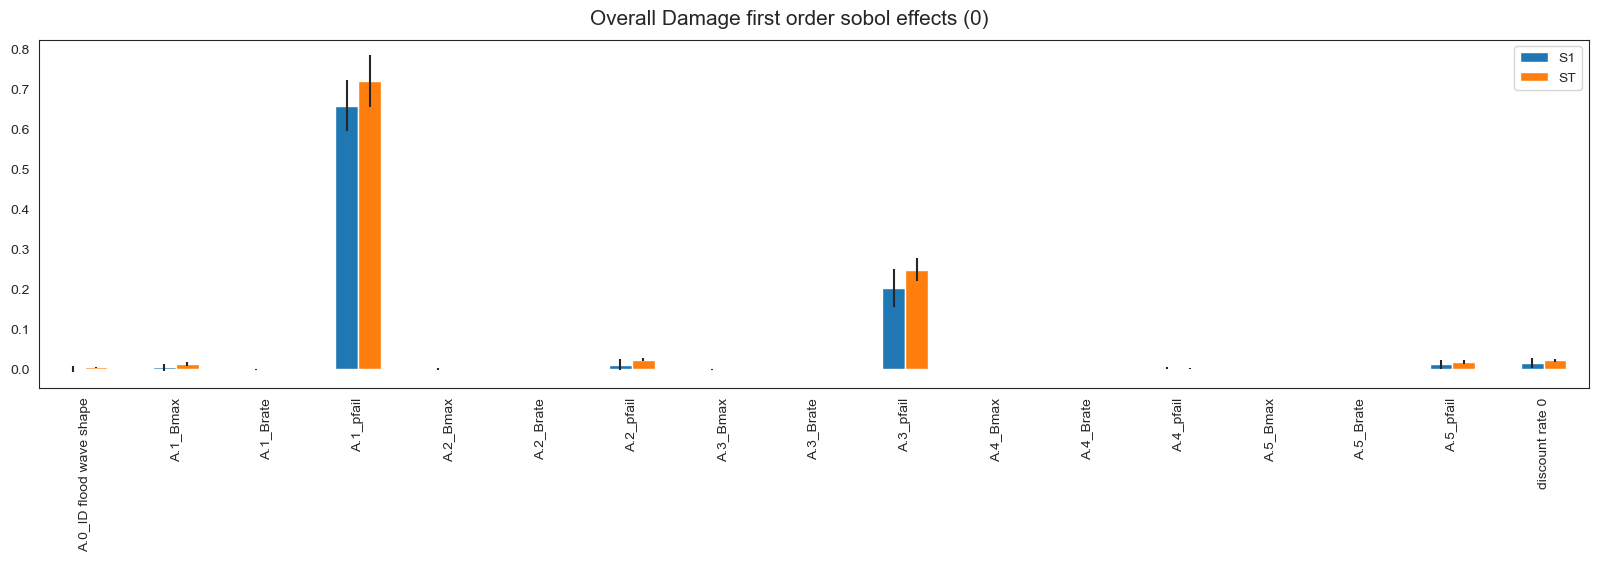

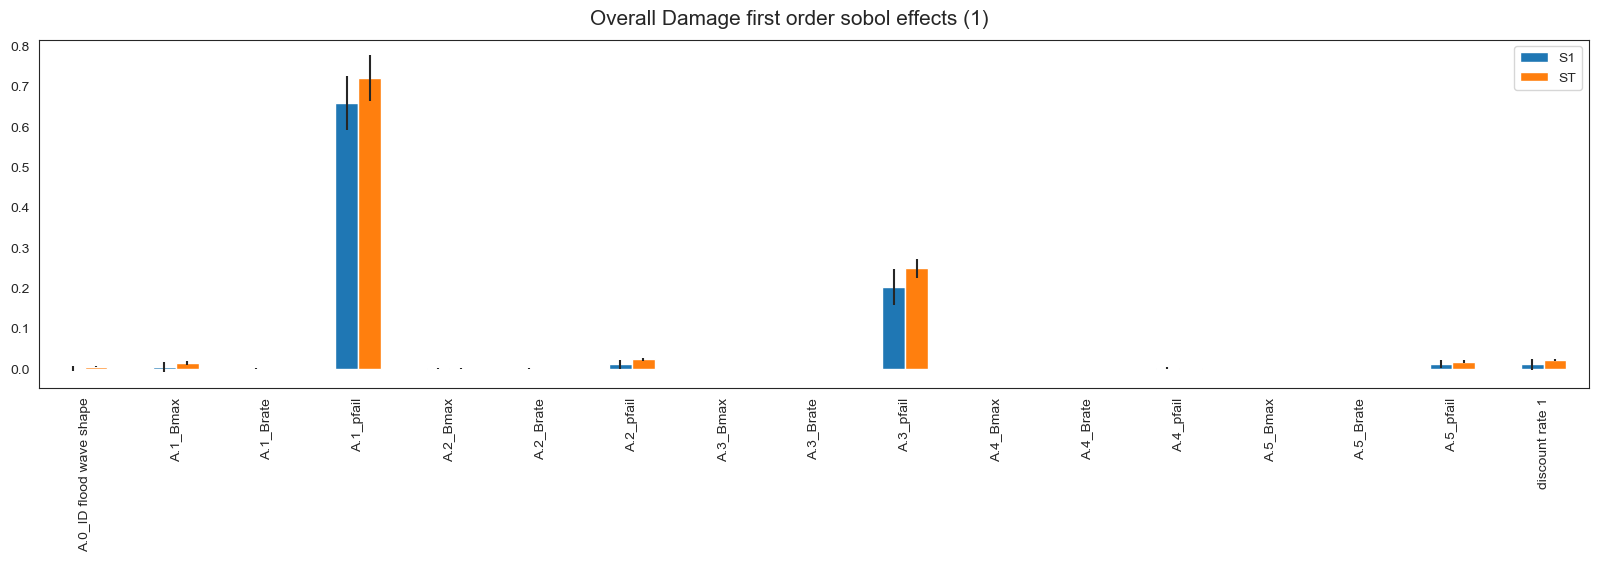

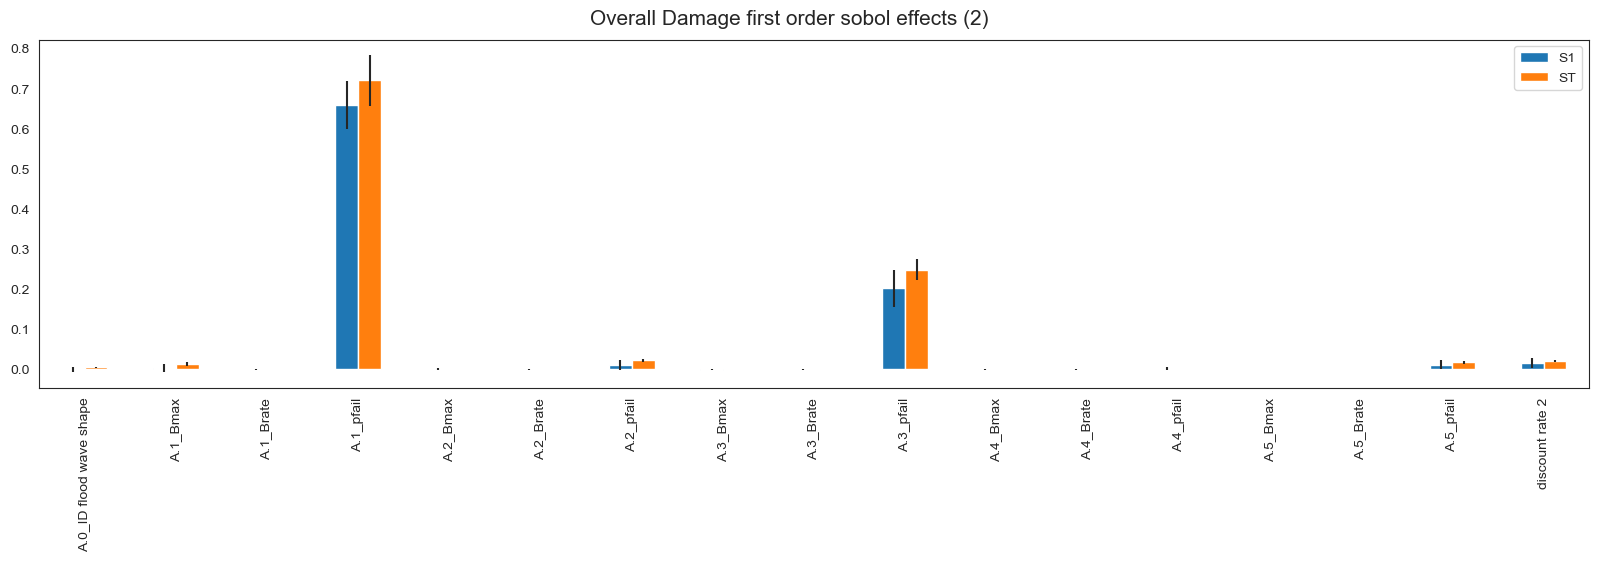

In [13]:
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'first','all')
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'first','0')
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'first','1')
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'first','2')

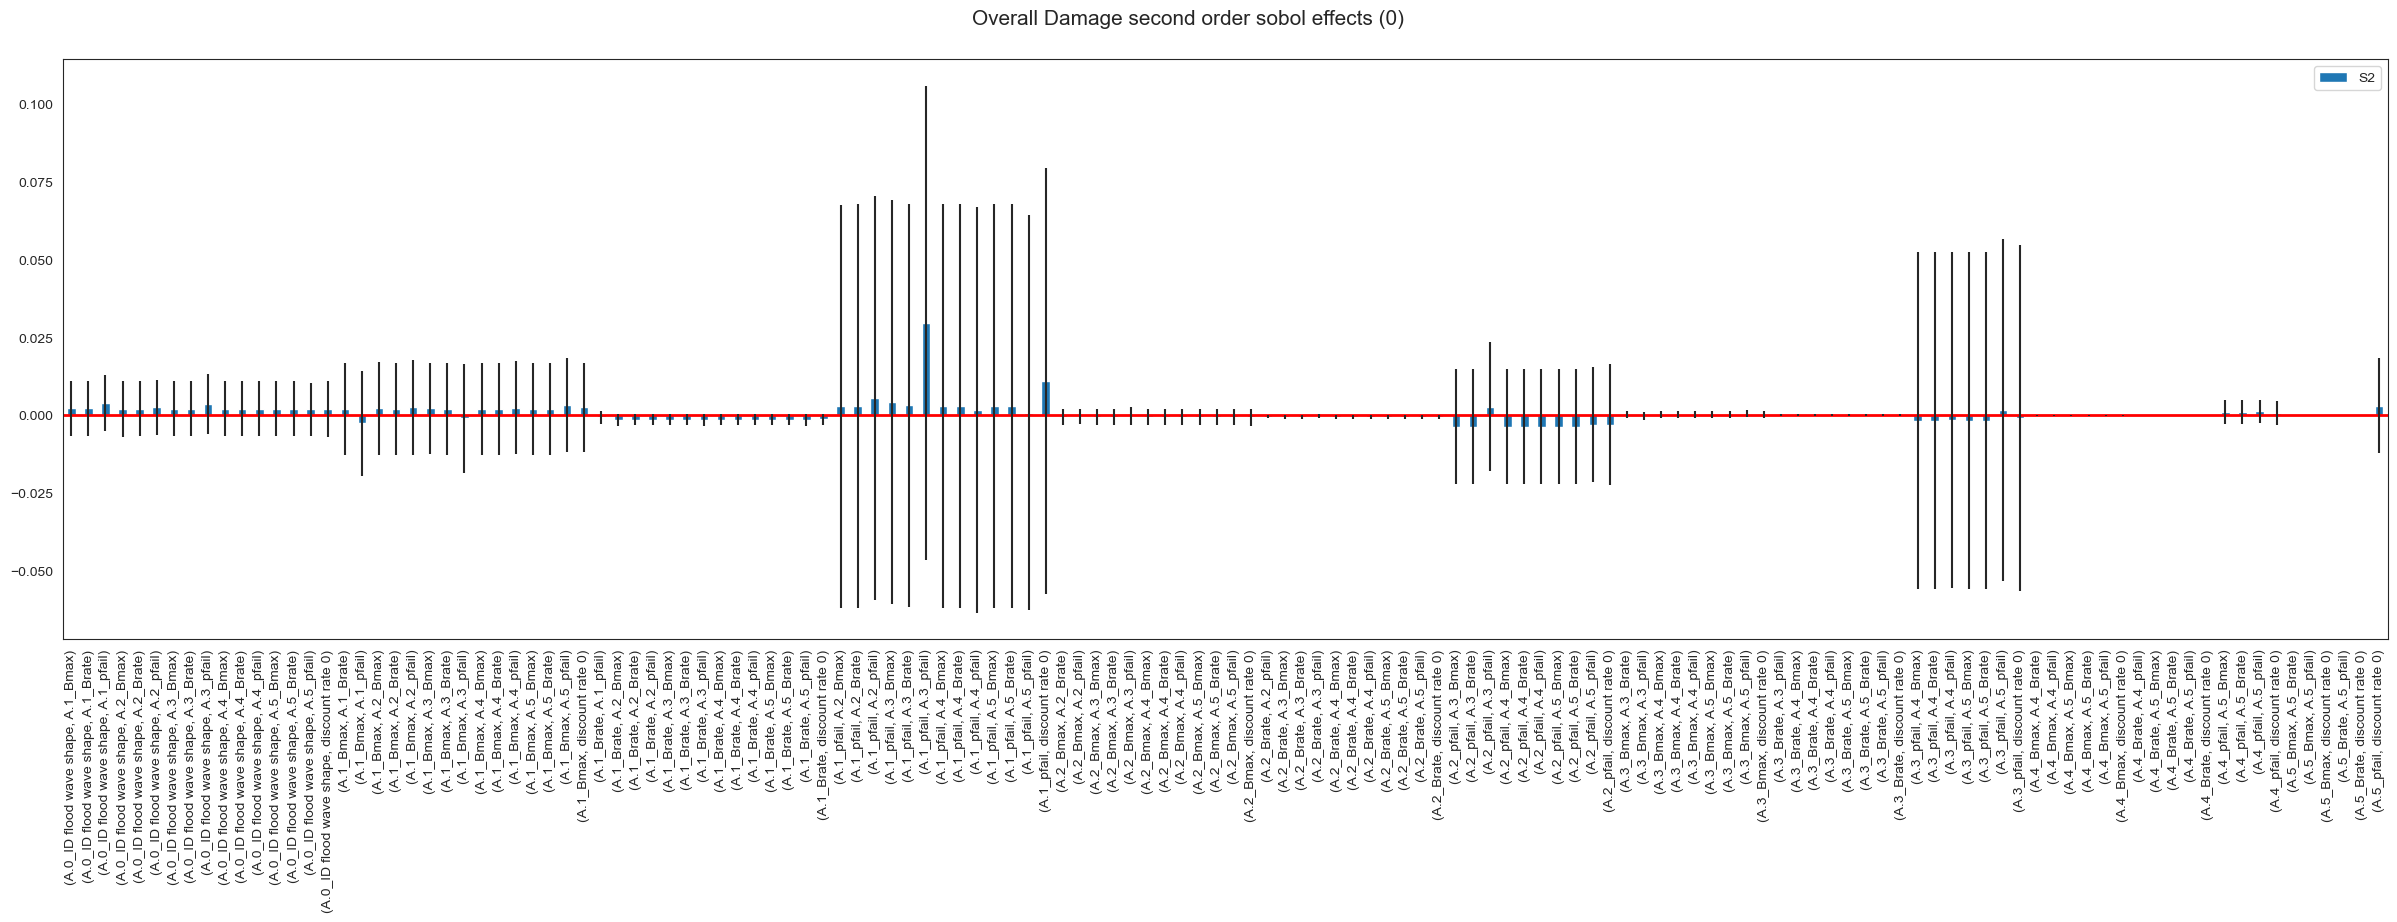

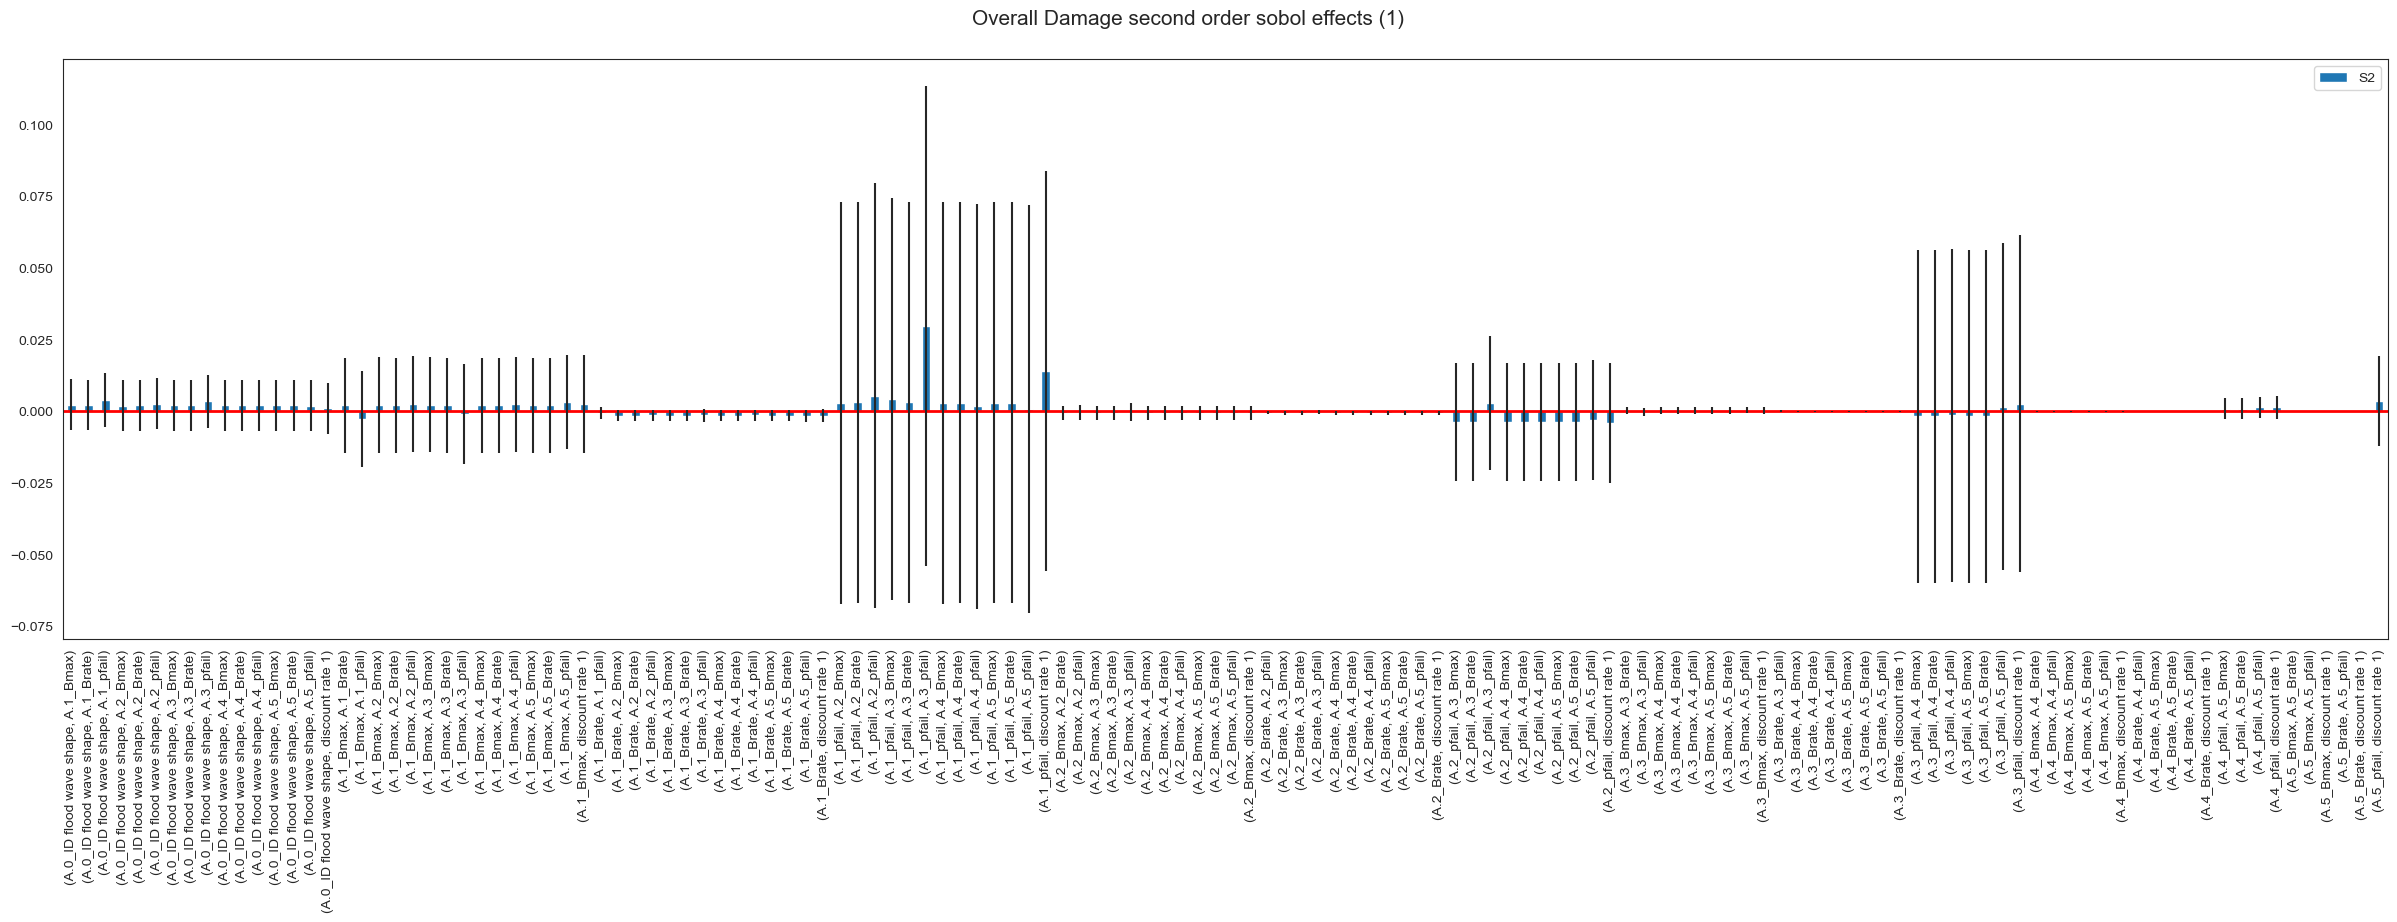

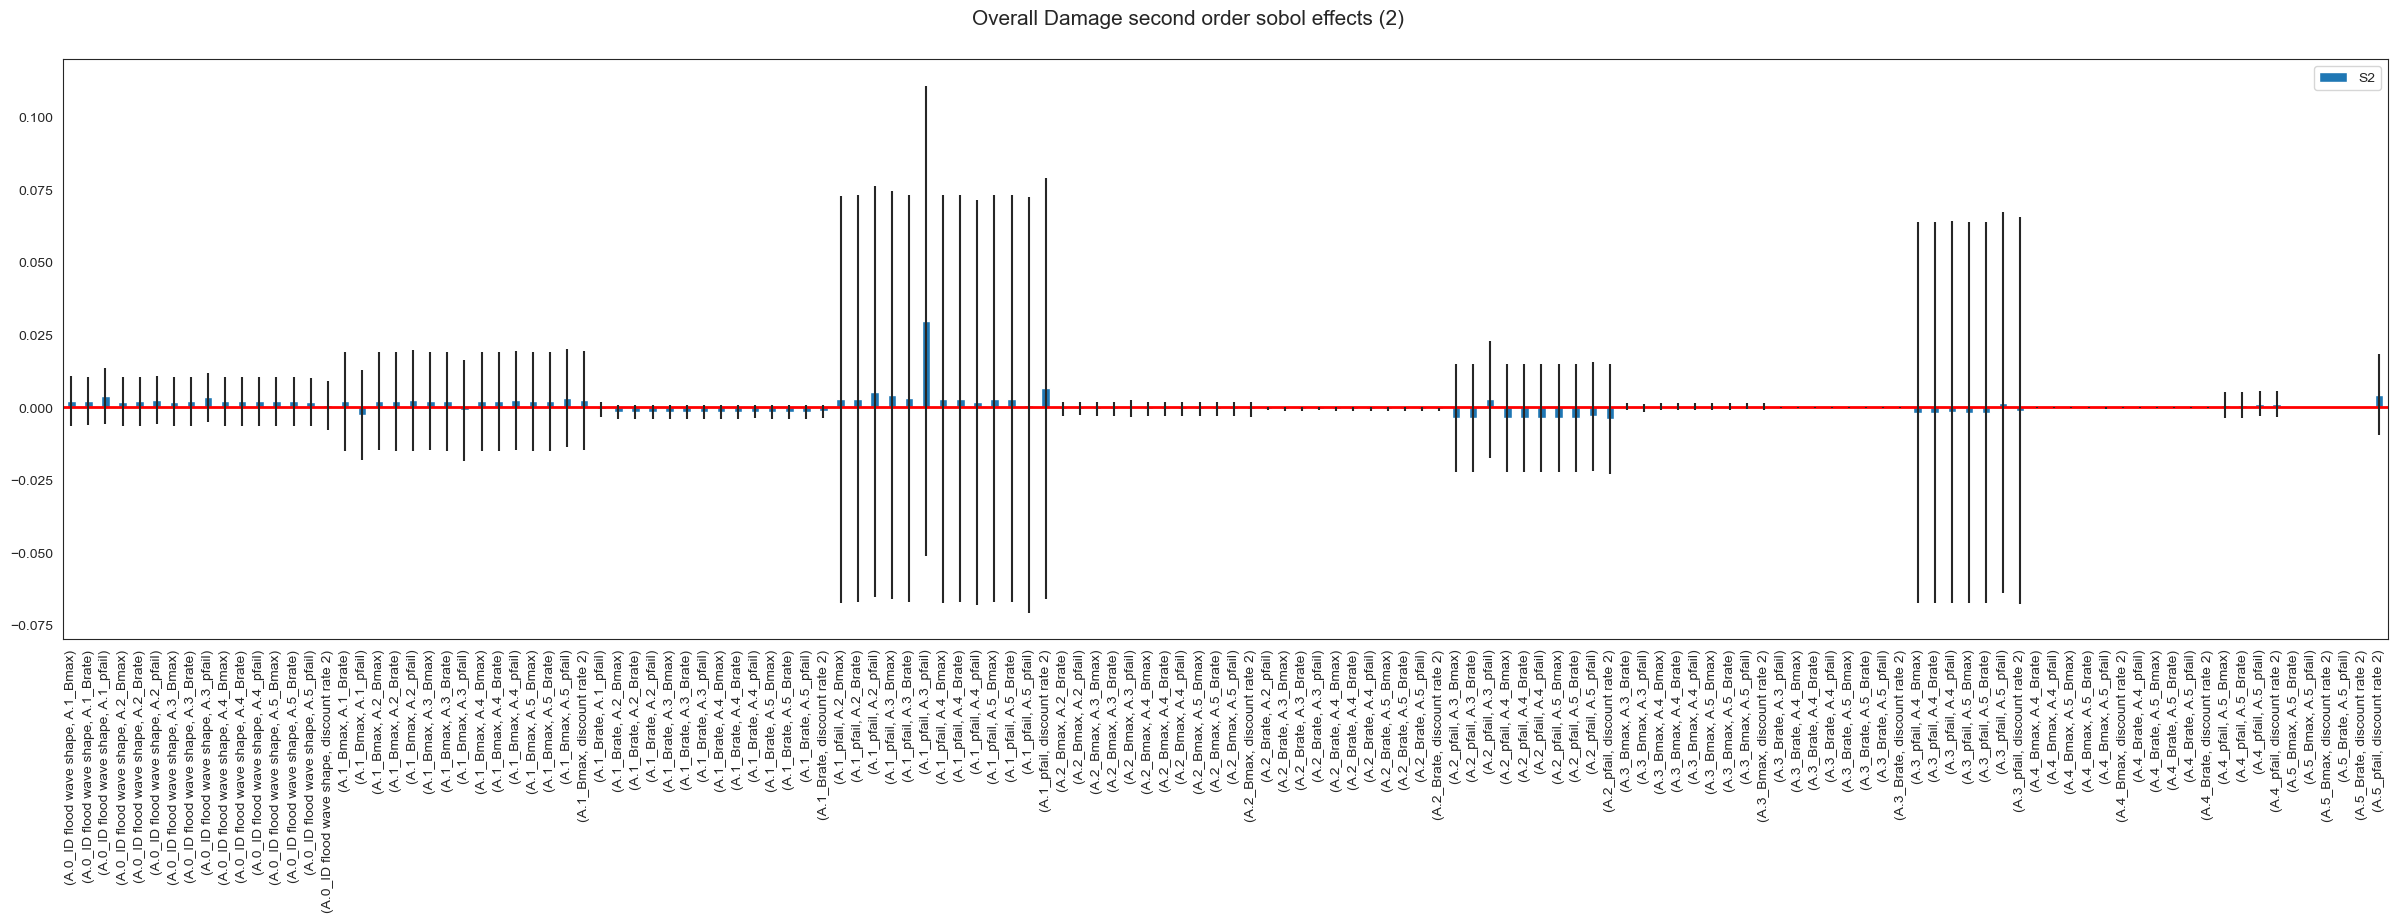

In [14]:
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'second','0')
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'second','1')
plot_sobol_effects(uncertainty_space_dict,'Overall Damage', 'second','2')

In [15]:
# # Assuming Si_filter_s2 and S2_df are generated as in your code snippet

def sort_second_order_overall_effects(variable):
    problem = get_SALib_problem(uncertainties)
    Si = sobol.analyze(problem, uncertainty_space_dict[variable], print_to_console=False)
    
    Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])
    
    Si_filter_s2 = {k: Si[k] for k in ['S2','S2_conf']}
    S2_df = pd.DataFrame(flatten_dict_arrays(Si_filter_s2), index=list(itertools.product(problem['names'], repeat=2)))

    # Sort S2_df by 'S2' in descending order
    S2_df_sorted = S2_df.sort_values(by='S2', ascending=False)

    # Filter rows where 'S2' > 0
    S2_df_sorted_filtered = S2_df_sorted[abs(S2_df_sorted['S2']) > 0.01]

    # Visualize Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    # Drop NaN values from 'S2' and 'S2_conf' columns
    indices = S2_df_sorted_filtered[["S2"]].dropna()
    err = S2_df_sorted_filtered[['S2_conf']].dropna()

    # Plotting bar chart
    indices.plot.bar(yerr=err.values.T, ax=ax)
    
    # Set x-axis label fontsize
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

    # Adding title and adjusting figure
    fig.suptitle(f'{variable} sorted', fontsize=15, y=0.93)
    fig.set_size_inches(40, 20)  # Adjust figure size as needed
    fig.subplots_adjust(bottom=0.3)

    plt.show()
    return

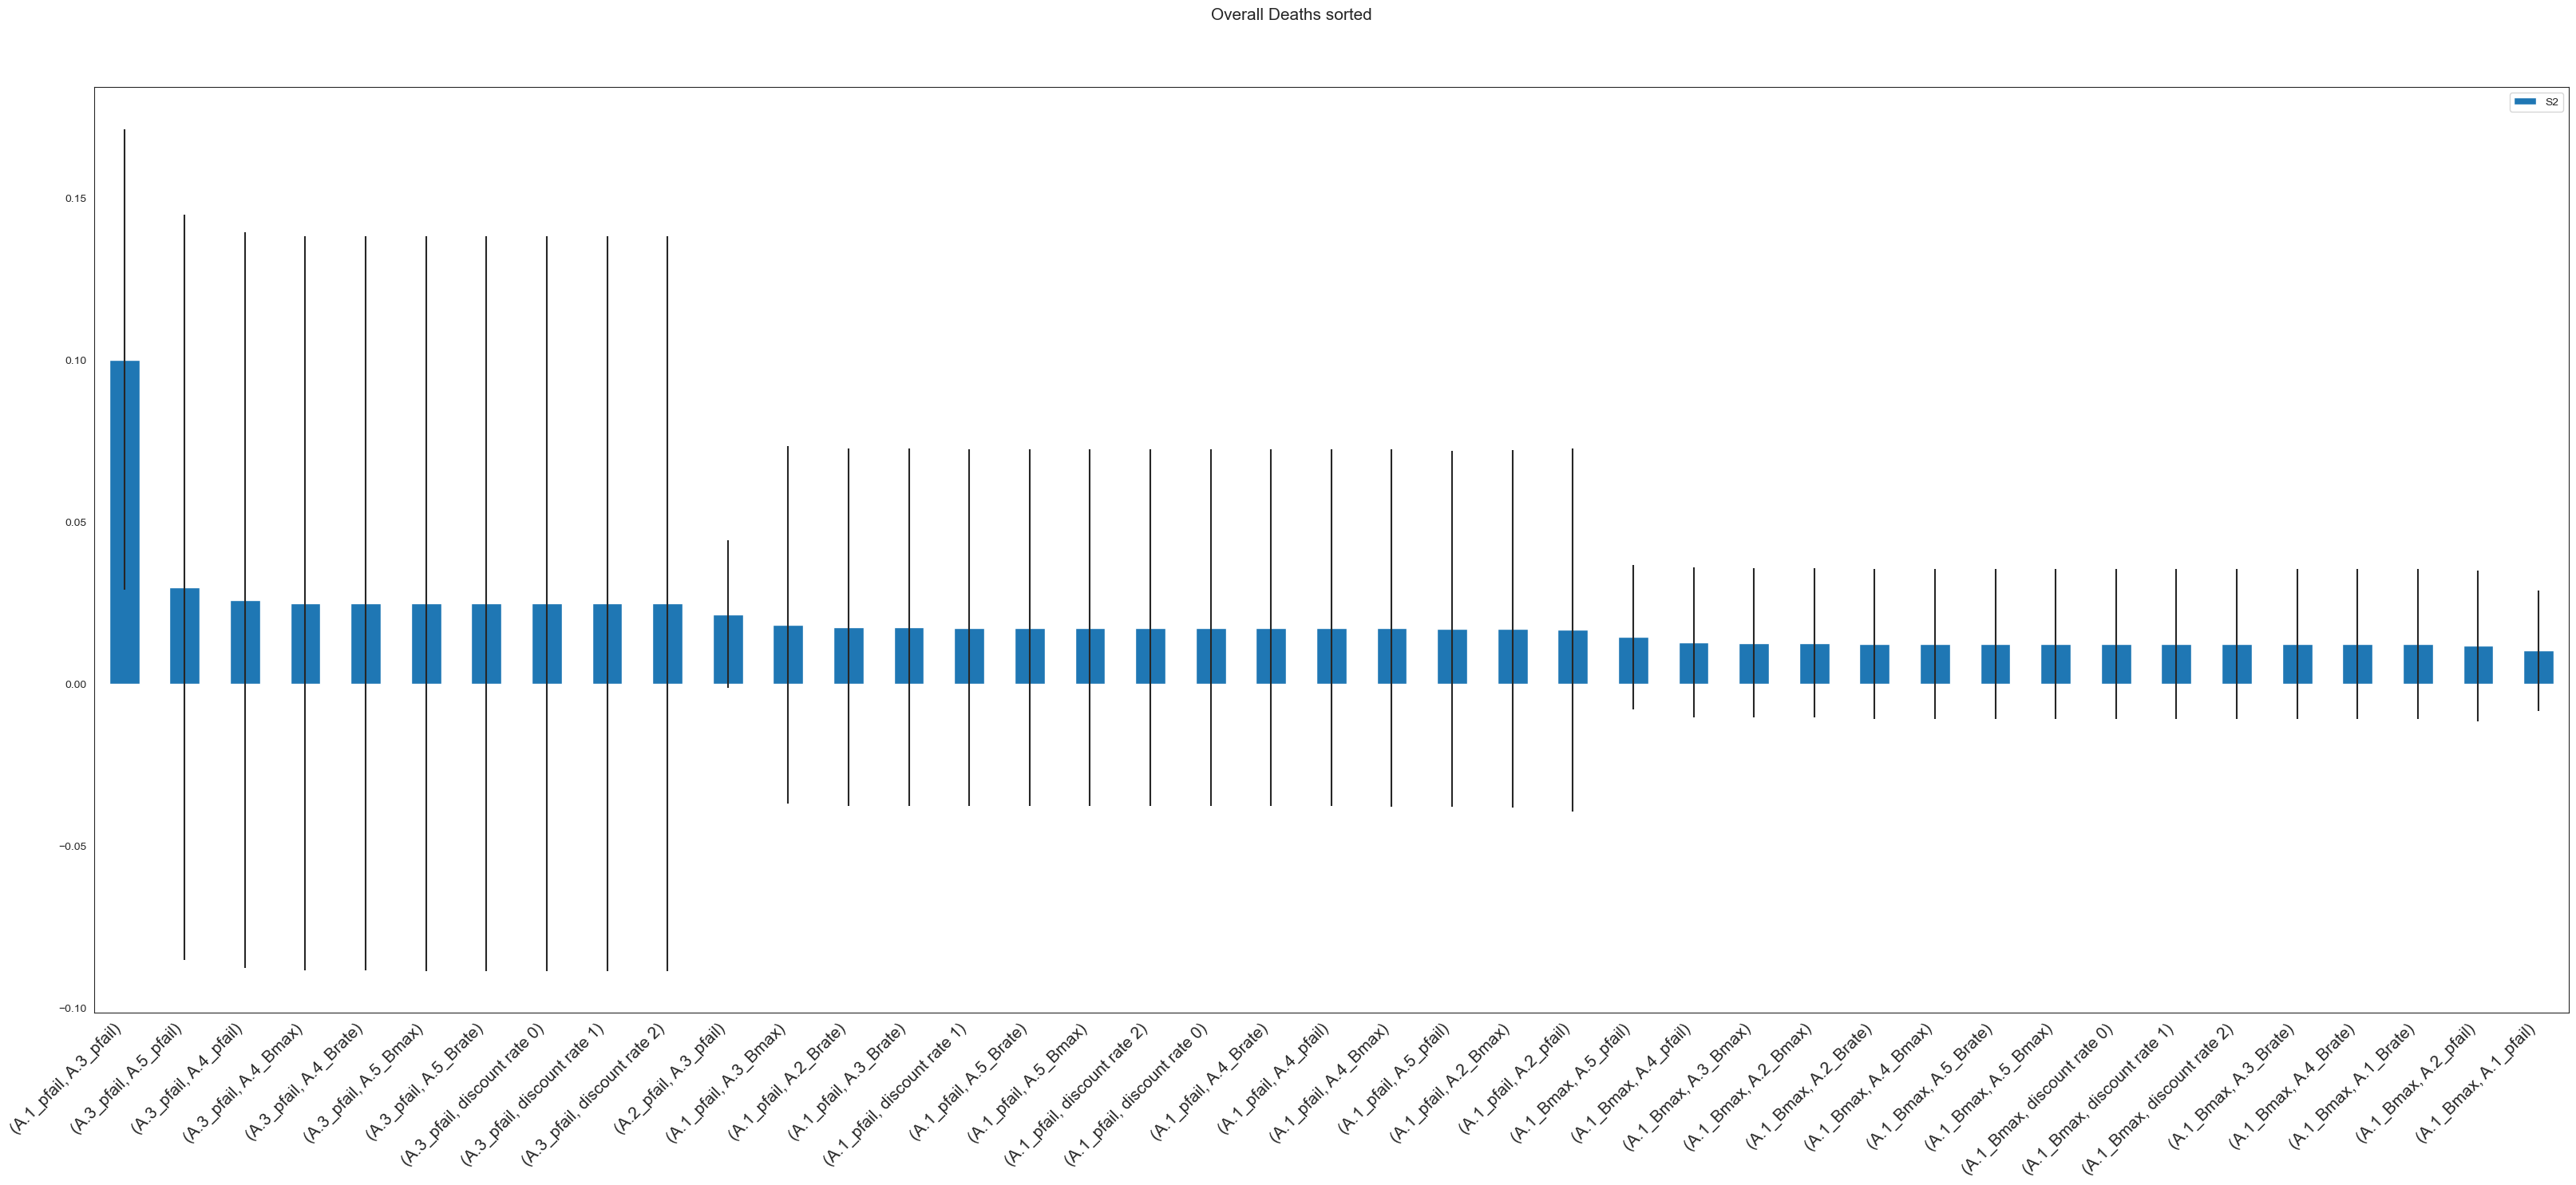

In [16]:
sort_second_order_overall_effects('Overall Deaths')

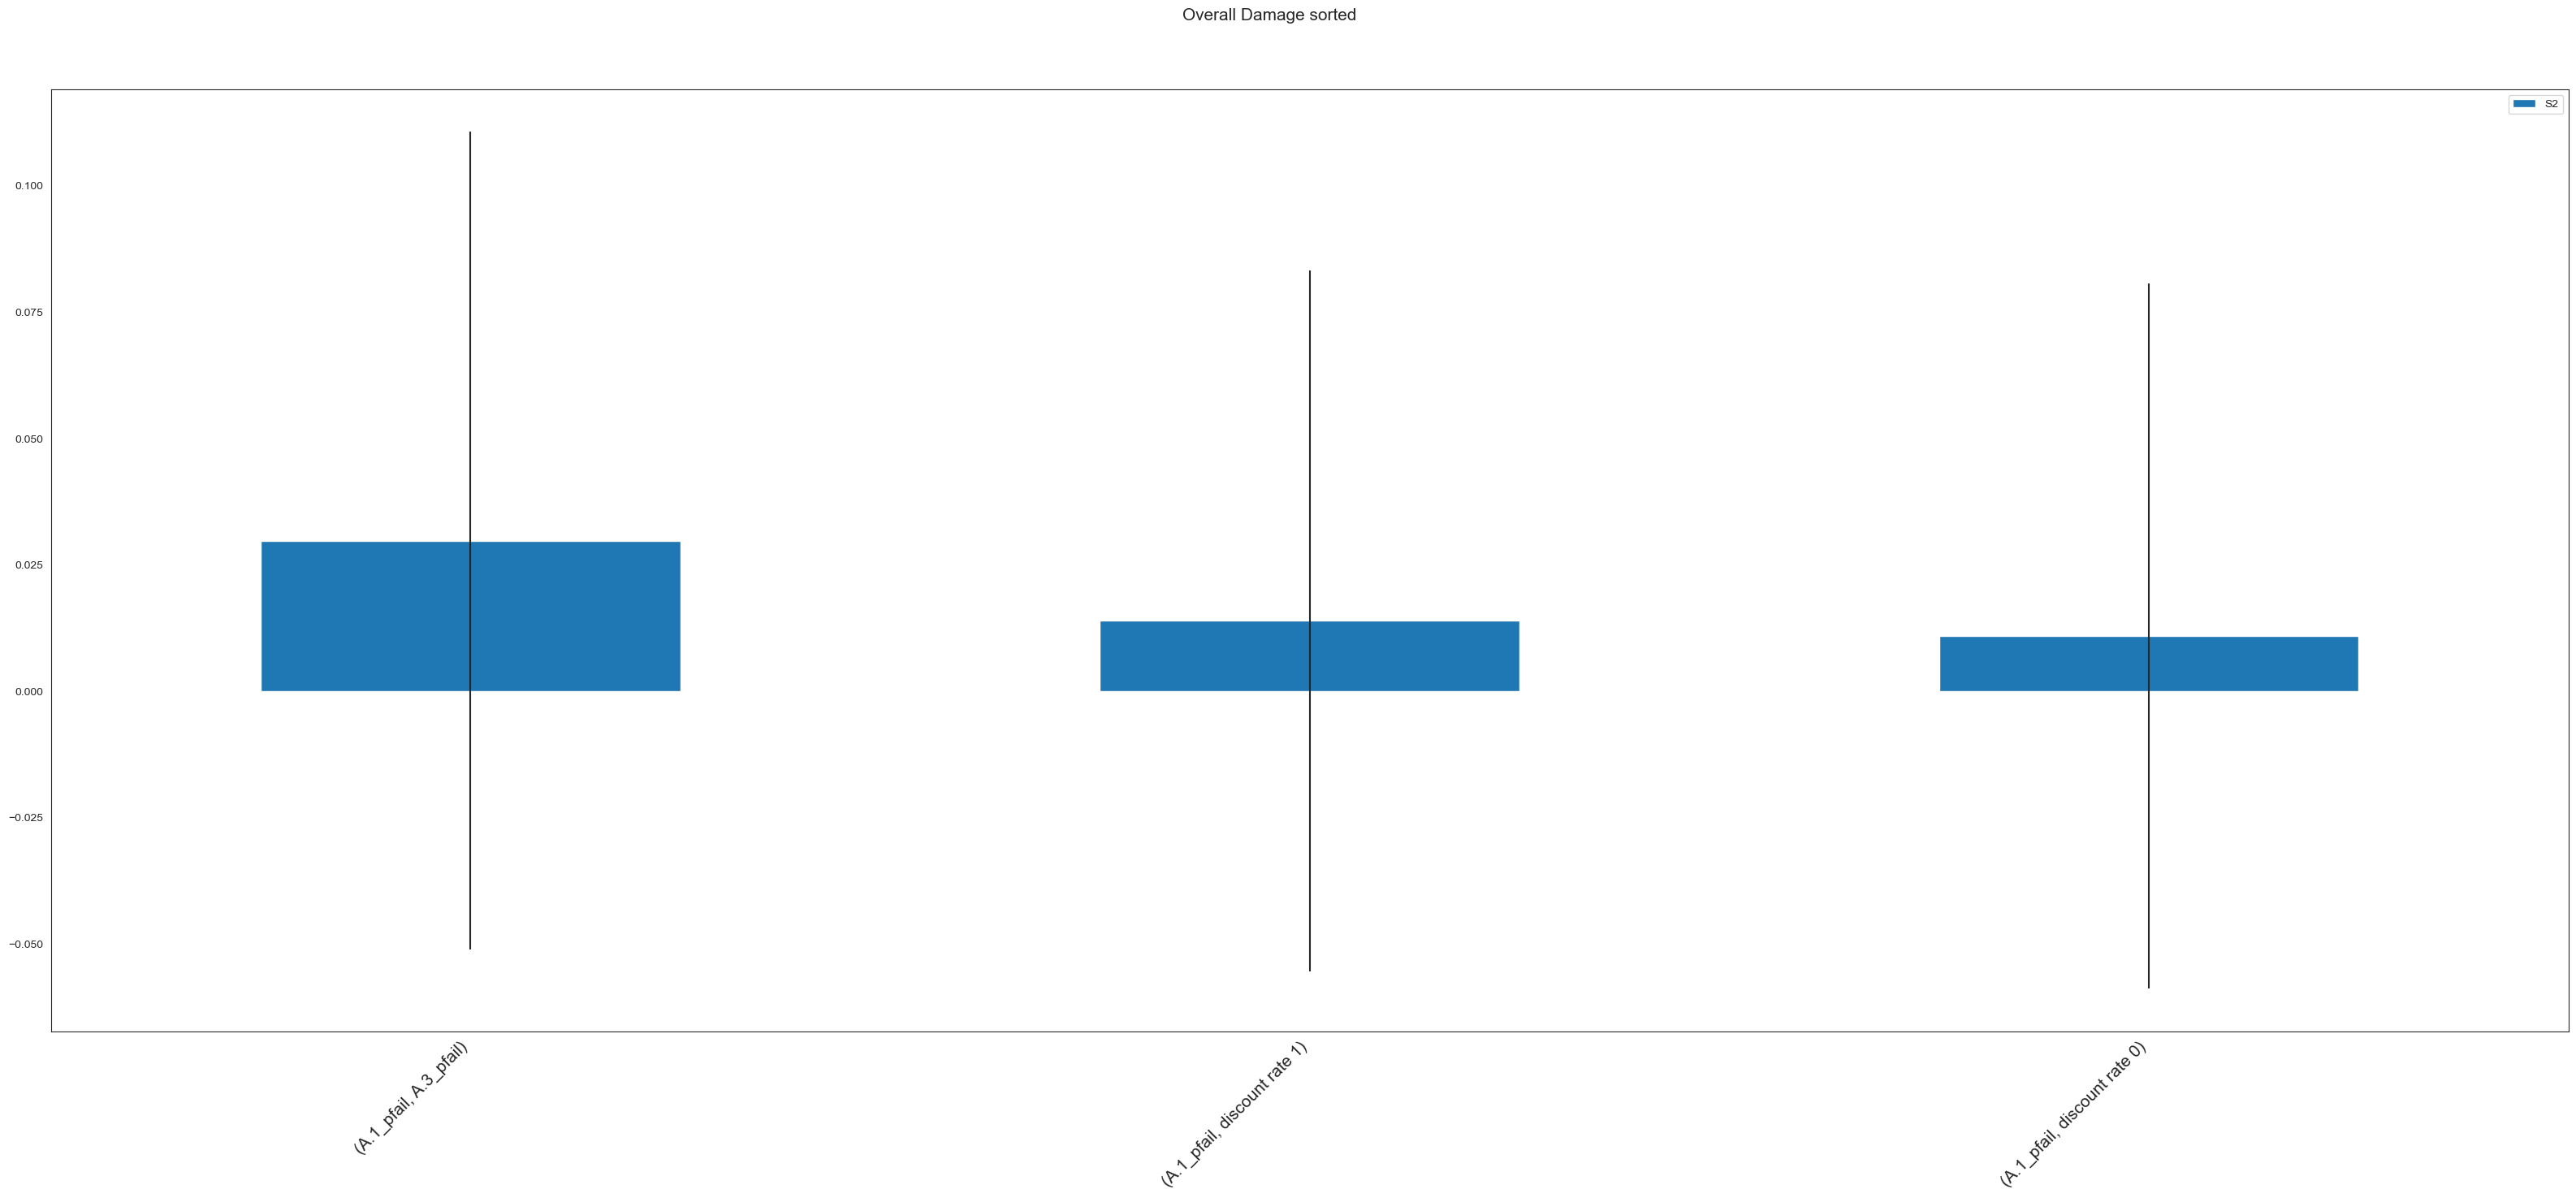

In [17]:
sort_second_order_overall_effects('Overall Damage')

## 4. Feauture scoring

It is interesting to see which uncertainties and policy levers impact the outcomes on both an aggregated as a disaggregated level. For this reason the contribution of each uncertainty & lever to these outcomes is depicted in a heatmap produced by feature scoring.

In [18]:
# Create a dataframe only containing the aggregated results added to the outcomes
aggregate_uncertainty_space = uncertainty_space[['Overall Damage', 'Overall Deaths', 'Aggregated Investment','Project and Damage Costs']]
# aggregate_uncertainty_space

C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


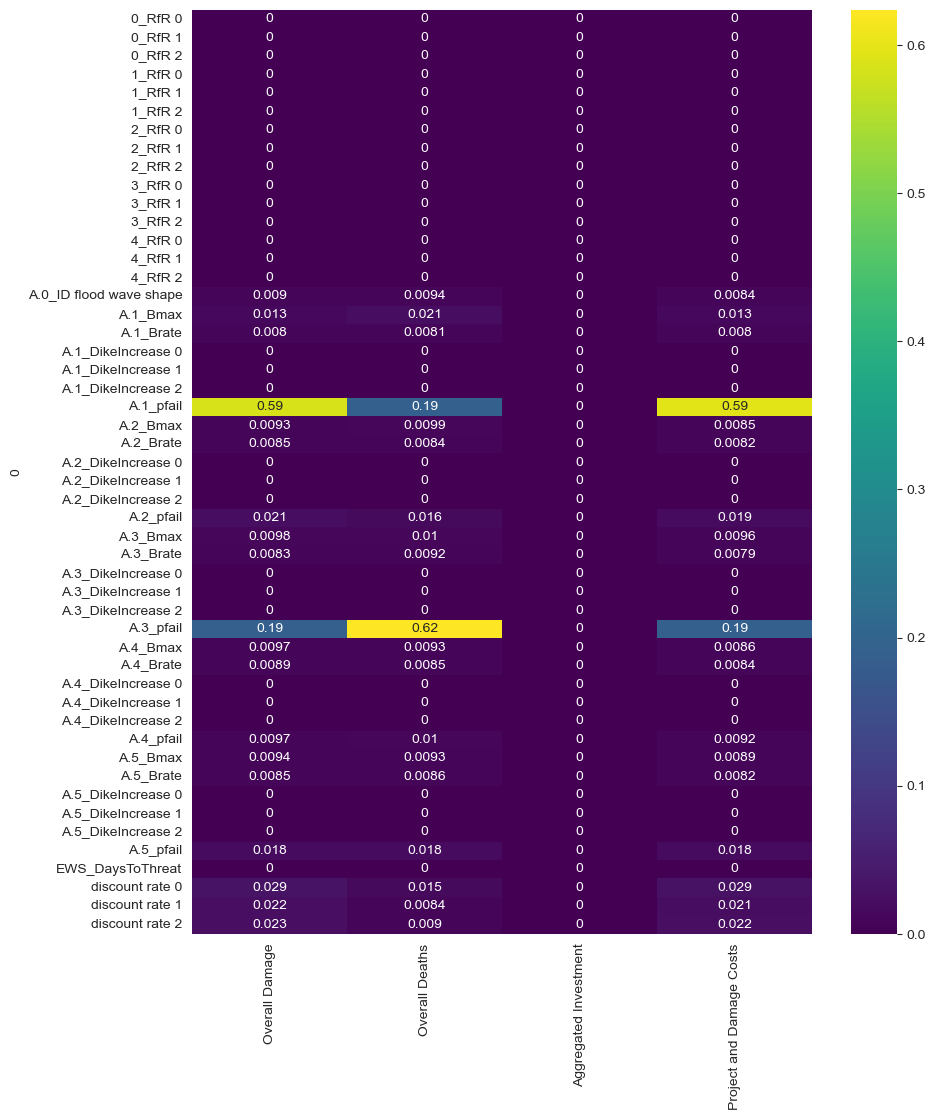

In [19]:
from sklearn.preprocessing import StandardScaler

## Aggregated feature scoring
x = pol_experiments_df
y = aggregate_uncertainty_space

fs = feature_scoring.get_feature_scores_all(x, y)

plt.figure(figsize=(10, 12))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

On a national level you can see that A.1_pfail and A.3_pfail have the most influence on the outcomes.

C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\mnmar\anacondaGoede\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


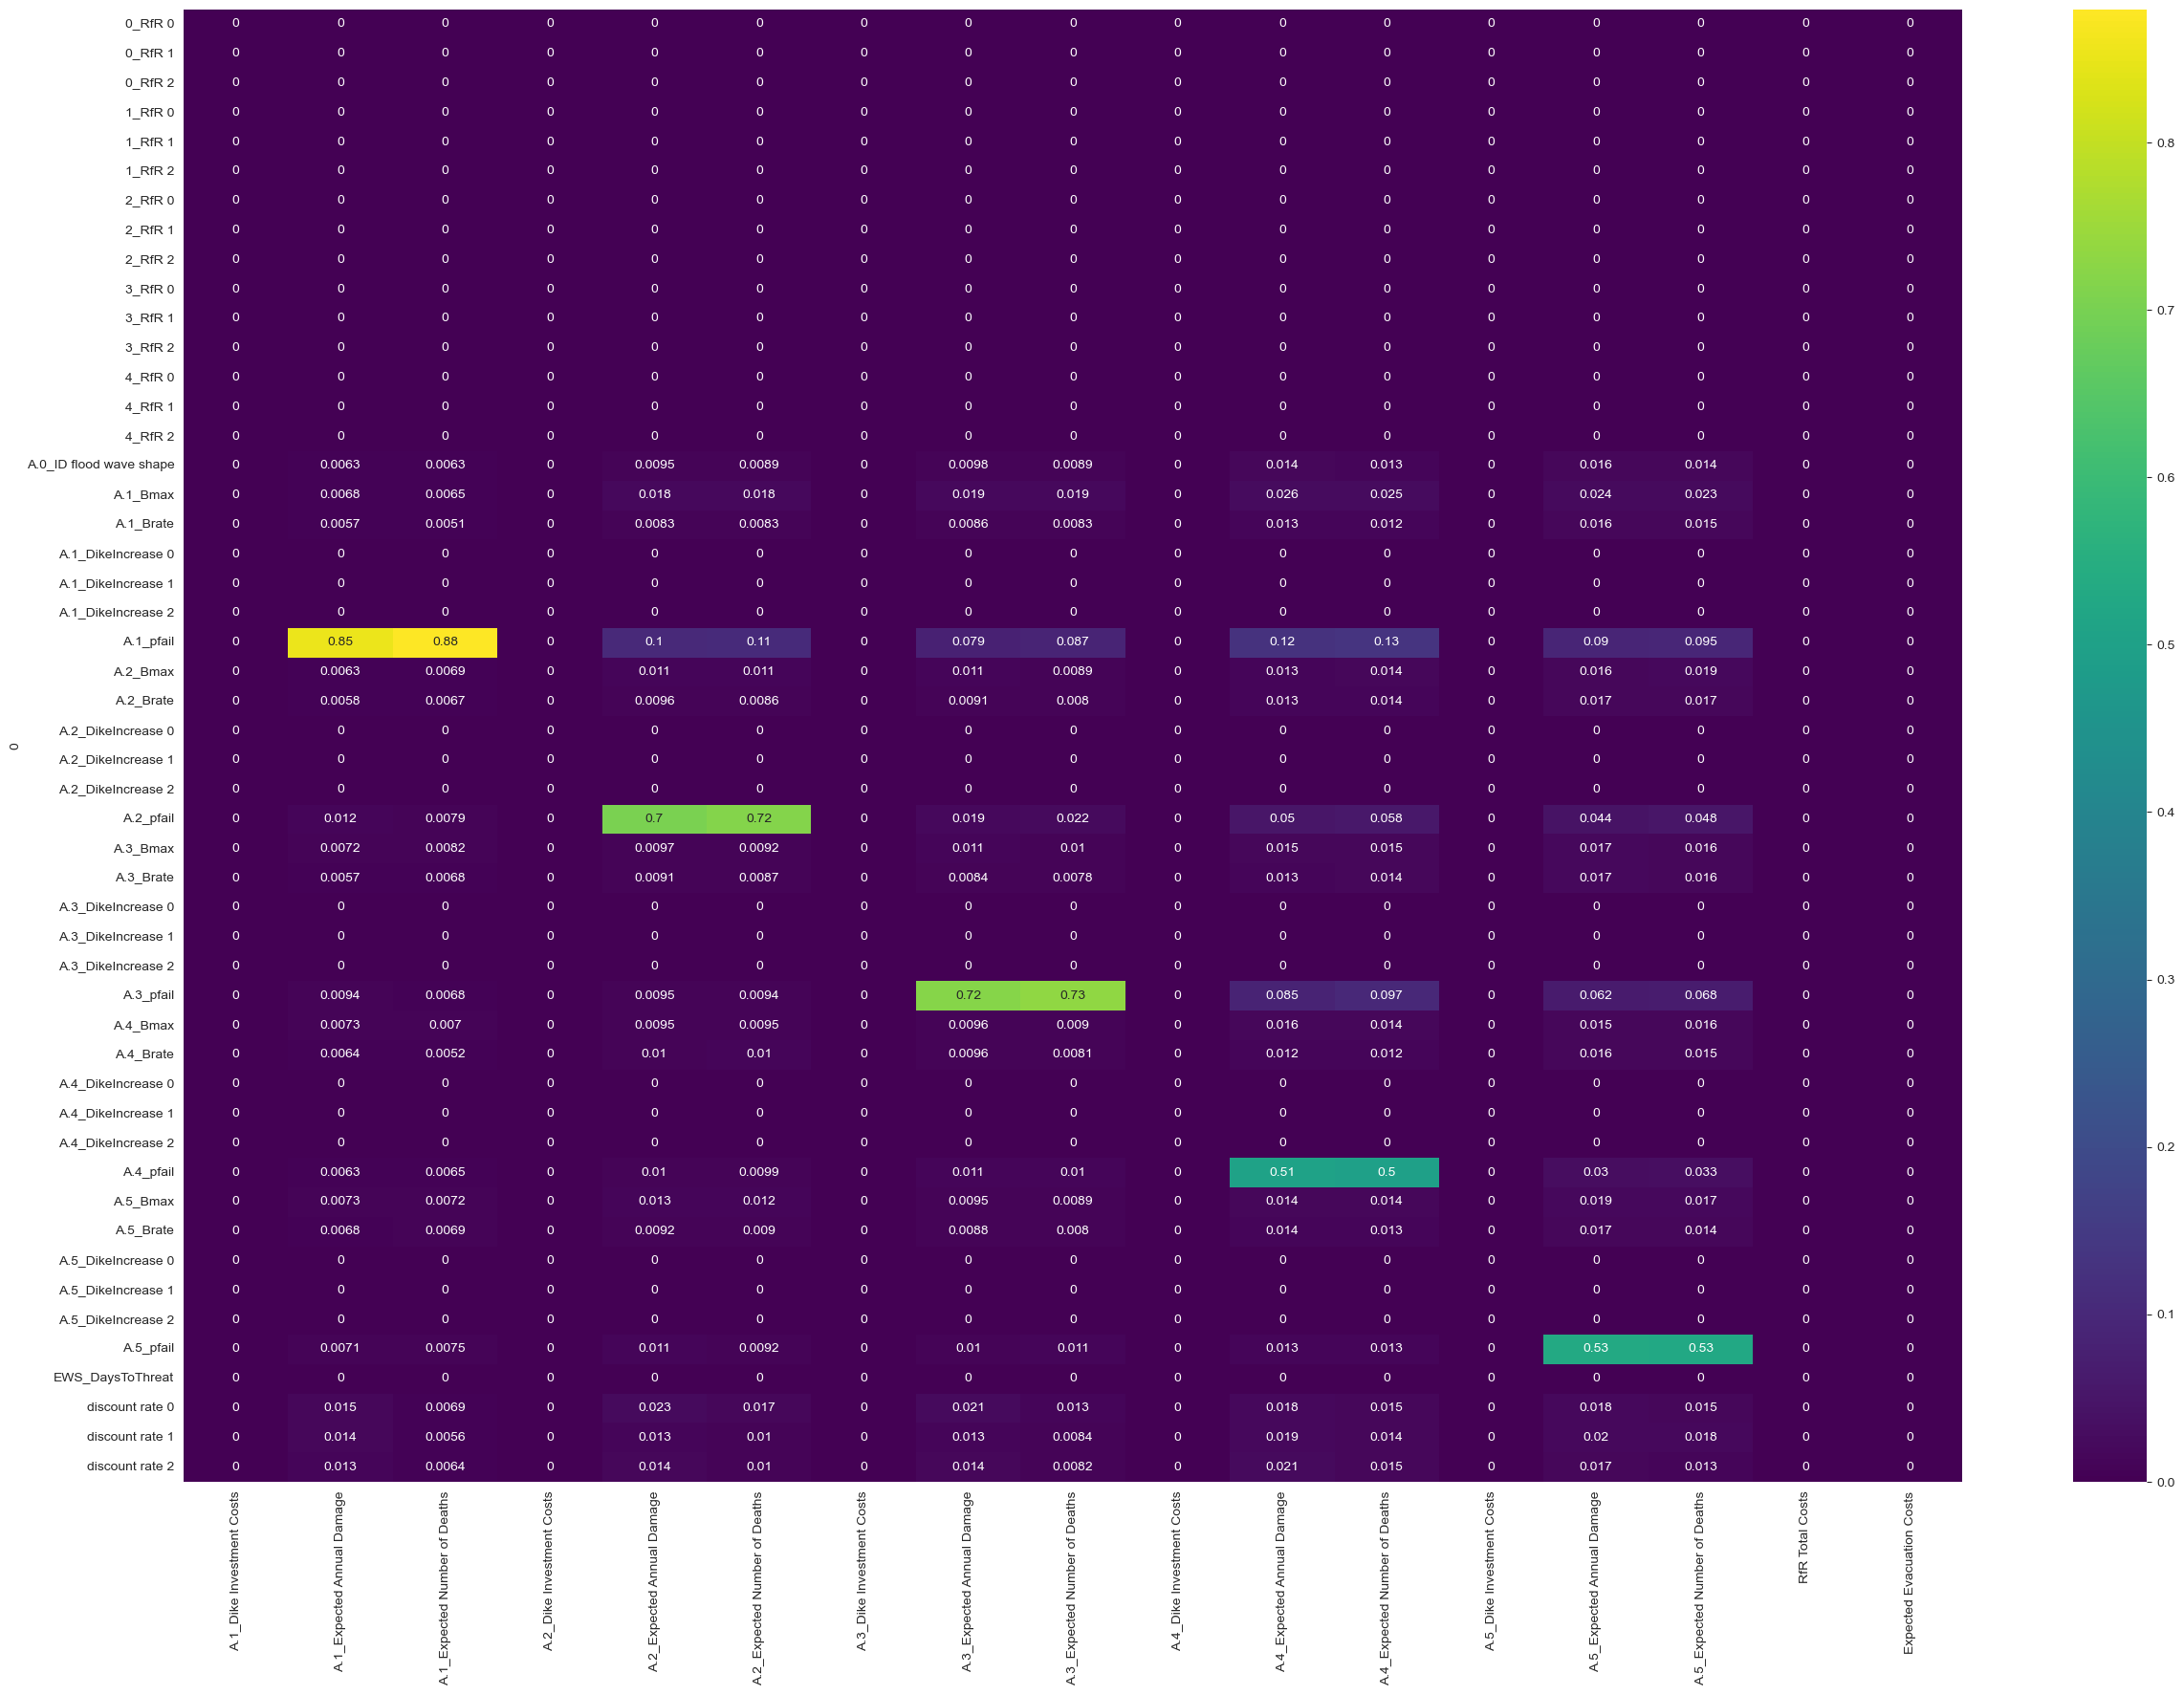

In [20]:
## Disaggregated feature scoring: inspect the results on a local level to predict policy constraints

x = pol_experiments_df
y = uncertainty_outcomes_df

fs = feature_scoring.get_feature_scores_all(x, y)

plt.figure(figsize=(30, 20))
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

On a regional level it shows that all the pfails have a influence on the expected annual damage and expected number of deaths per location. The uncertainty has a higher influence at the first 3 locations.